import seaborn as sns
# ^^^ pyforest auto-imports - don't write above this line
In this notebook, we are going to explore the peak detection algorithm applied to ECG data in order to infer the heart rate and try to reconstruct the QRS peak. Following Tim's 2011 paper, ECG data is bandpass filtered for frequency ranges [0.6 - 2.0] Hz.

In [1]:
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
import numpy as np
import sys
sys.path.append("/home/javi/Documents/brainhack-physio-project/code")
from input import getECGData, getInfoData
from events import compute_max_events
from clean import butter_bandpass_filter
from scipy.signal import welch

In [117]:
def generate_plots(signal, low_cut, high_cut, fs, delta, peak_rise):
    signal = signal - np.mean(signal)
    signal_filt = butter_bandpass_filter(signal,lowcut=low_cut, highcut=high_cut, fs=fs)
    
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,10))
#     # Plot signal for 5 seconds signal
#     ax = axs[0,0]
#     ax.plot(signal, label="unfiltered signal", alpha=0.5)
#     ax.plot(signal_filt, label="filtered signal")
#     ax.set_xlim([5000, 10000])
#     ax.legend()

    # Show how frequencies are filtered 
    ax = axs[0,1]
    f, Pxx = welch(signal, fs=fs, nperseg=2048, scaling="spectrum")
    ax.semilogy(f, Pxx, label="unfiltered signal")
    f, Pxx = welch(signal_filt, fs=fs, nperseg=2048, scaling="spectrum")
    ax.semilogy(f, Pxx, label="filtered signal")
    ax.set_xlabel("Frequency (Hz)", size=20)
    ax.set_ylabel("Power spectrum", size=20)
    ax.set_xlim([0,20])
    ax.legend()

    # Compute peaks and plot a portion of data (5 secs)
    ax = axs[1,0]
    peaks = compute_max_events(signal_filt, peak_rise=peak_rise, delta=delta)
    n_peaks = len(peaks)

    diff_peaks = abs(np.diff(peaks))
    
    # Heart rate using the difference time between peaks
    heart_rate = np.mean(fs/diff_peaks)*60

    ax.plot(signal_filt)
    ax.scatter(peaks.astype(int), signal_filt[peaks.astype(int)], c="red", marker="x", s=100)
    ax.set_xlim([5000, 10000])

    # Compute signal around peaks
    ax = axs[0,0]
    
    sign_peaks = []
    for pk in peaks.astype(int):
        i_0 = pk-delta
        i_f = pk+delta
        if i_0 < 0:
            continue
        if i_f > len(signal_filt):
            continue
        sign_peaks.append(signal_filt[i_0:i_f])

    ax.plot(np.mean(np.array(sign_peaks), axis=0))
    ax.errorbar(x=np.arange(2*delta),
             y = np.mean(np.array(sign_peaks), axis=0),
             yerr = np.std(np.array(sign_peaks), axis=0),
                alpha=0.5
            )

    #ax.hist(diff_peaks/400, density=True, alpha=0.7)
    #ax.vlines(np.mean(diff_peaks/400), ymin=0, ymax=ax.get_ylim()[1], color="red", linestyles="--")
    ax.set_title(f"Average signal around peaks (HR ={heart_rate:.2f})", size=20)
    
    # Plot interval peaks
    ax = axs[1,1]
    sns.histplot(diff_peaks/fs, kde=True, bins=100, ax=ax)
    ax.set_title(f"Number of peaks: {n_peaks}", size=30)
    ax.set_xlabel("Between-peaks duration (sec)", size=20)
    
#     sns.kdeplot
#     axs[1].hist(diff_peaks/fs, bins=100)
#     axs[1].set_title(f"Number of peaks: {n_peaks}", size=20)
    
    for ax in axs.flatten():
        ax.tick_params(labelsize=20)
    plt.tight_layout()
    
def peak_det_qc(signal, low_cut, high_cut, fs, delta, peak_rise):
    signal = signal - np.mean(signal)
    signal_filt = butter_bandpass_filter(signal,lowcut=low_cut, highcut=high_cut, fs=fs)
    
    fig, axs = plt.subplots(ncols=2, figsize=(15,7))
    
    peaks = compute_max_events(signal_filt, peak_rise=peak_rise, delta=delta)
    n_peaks = len(peaks)
    
    diff_peaks = abs(np.diff(peaks))
    # Heart rate using the difference time between peaks
    heart_rate = np.mean(fs/diff_peaks)*60
    
    sign_peaks = []
    for pk in peaks.astype(int):
        i_0 = pk-delta
        i_f = pk+delta
        if i_0 < 0:
            continue
        if i_f > len(signal_filt):
            continue
        sign_peaks.append(signal_filt[i_0:i_f])

    axs[0].plot(np.mean(np.array(sign_peaks), axis=0))
    axs[0].errorbar(x=np.arange(2*delta),
             y = np.mean(np.array(sign_peaks), axis=0),
             yerr = np.std(np.array(sign_peaks), axis=0),
                alpha=0.5
            )

    axs[0].set_title(f"Average signal around peaks (HR ={heart_rate:.2f})", size=30)
    
    # Plot interval peaks
    
    axs[1].hist(diff_peaks/fs, bins=100)
    axs[1].set_title(f"Number of peaks: {n_peaks}", size=30)
    plt.tight_layout()

[21889410. 21889411. 21889412. 21889413. 21889414. 21889415. 21889416.
 21889417. 21889418. 21889419.]

[[2970. 2817. 1905. 1828.]
 [3004. 2827. 1880. 1825.]
 [2992. 2797. 1862. 1831.]
 [2941. 2736. 1850. 1846.]
 [2861. 2652. 1844. 1865.]
 [2763. 2553. 1841. 1888.]
 [2653. 2446. 1837. 1909.]
 [2542. 2339. 1833. 1928.]
 [2440. 2236. 1831. 1942.]
 [2353. 2153. 1834. 1951.]]

ECG sampling rate: 400.00 Hz,
peak min separation: 200.00,
relative peak height min separation: 0.95,



<IPython.core.display.Javascript object>

CPU times: user 3.78 s, sys: 31.8 ms, total: 3.81 s
Wall time: 3.81 s


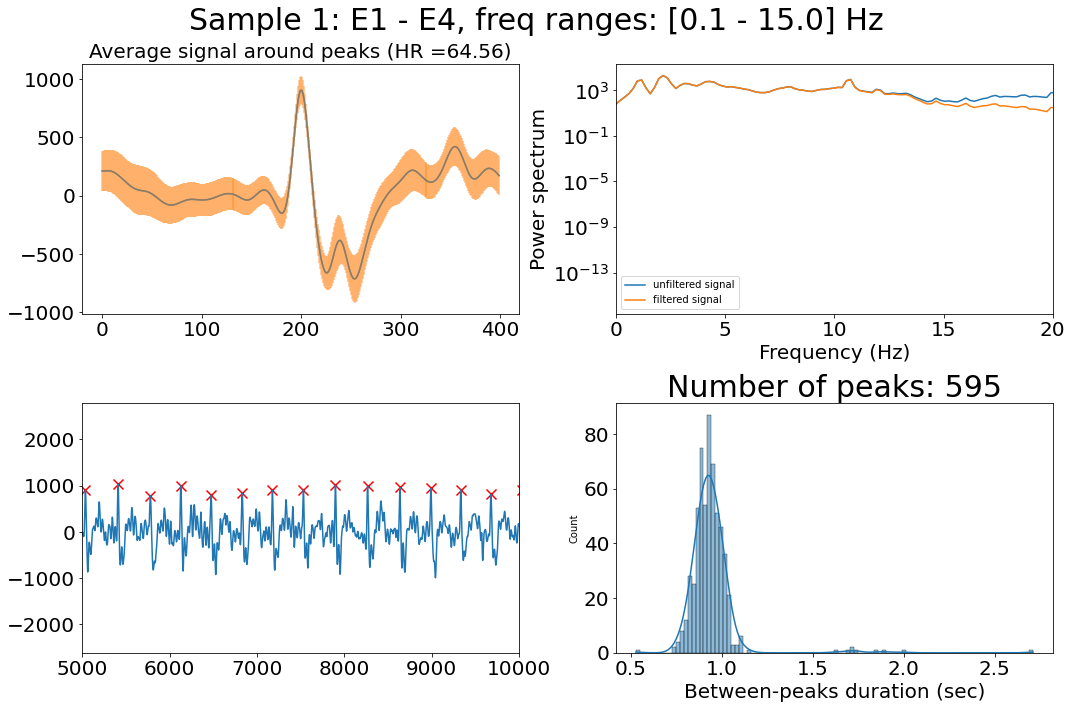

In [148]:
%%time
info,initial_time,final_time,n_vols,n_slices,rep_time = getInfoData('../data/sample1/Physio_sample1_Info.log', range(4))
ecg,_,_ = getECGData("../data/sample1/Physio_sample1_ECG.log", initial_time, final_time)

time_ecg=ecg[:,0]
print(time_ecg[:10])
print("")

ecg_signal=ecg[:,1:]
print(ecg_signal[:10,:])
print("")

fs = 400
low_cut = 0.1
high_cut = 15.0
delta = 200
peak_rise = 0.95

print("ECG sampling rate: %.2f Hz,\n"
     "peak min separation: %.2f,\n"
      "relative peak height min separation: %.2f,\n" % (fs, delta, peak_rise))

ix_1 = 0
ix_2 = 3
ground_ecg = ecg_signal[:,ix_1]

signal = ground_ecg - ecg_signal[:,ix_2] 

generate_plots(signal, low_cut=low_cut, high_cut=high_cut, fs=fs, delta=delta, peak_rise=peak_rise)
plt.suptitle(f"Sample 1: E{ix_1+1} - E{ix_2 +1}, freq ranges: [{low_cut} - {high_cut}] Hz", size=30)
plt.tight_layout()
plt.savefig("../plots/sample1_peaks_f0115.png", dpi=300)
plt.savefig("../plots/sample1_peaks_f0115.pdf", dpi=300)

[21889410. 21889411. 21889412. 21889413. 21889414. 21889415. 21889416.
 21889417. 21889418. 21889419.]

[[2970. 2817. 1905. 1828.]
 [3004. 2827. 1880. 1825.]
 [2992. 2797. 1862. 1831.]
 [2941. 2736. 1850. 1846.]
 [2861. 2652. 1844. 1865.]
 [2763. 2553. 1841. 1888.]
 [2653. 2446. 1837. 1909.]
 [2542. 2339. 1833. 1928.]
 [2440. 2236. 1831. 1942.]
 [2353. 2153. 1834. 1951.]]

ECG sampling rate: 400.00 Hz,
peak min separation: 200.00,
relative peak height min separation: 0.95,



<IPython.core.display.Javascript object>

CPU times: user 3.93 s, sys: 48 ms, total: 3.97 s
Wall time: 3.97 s


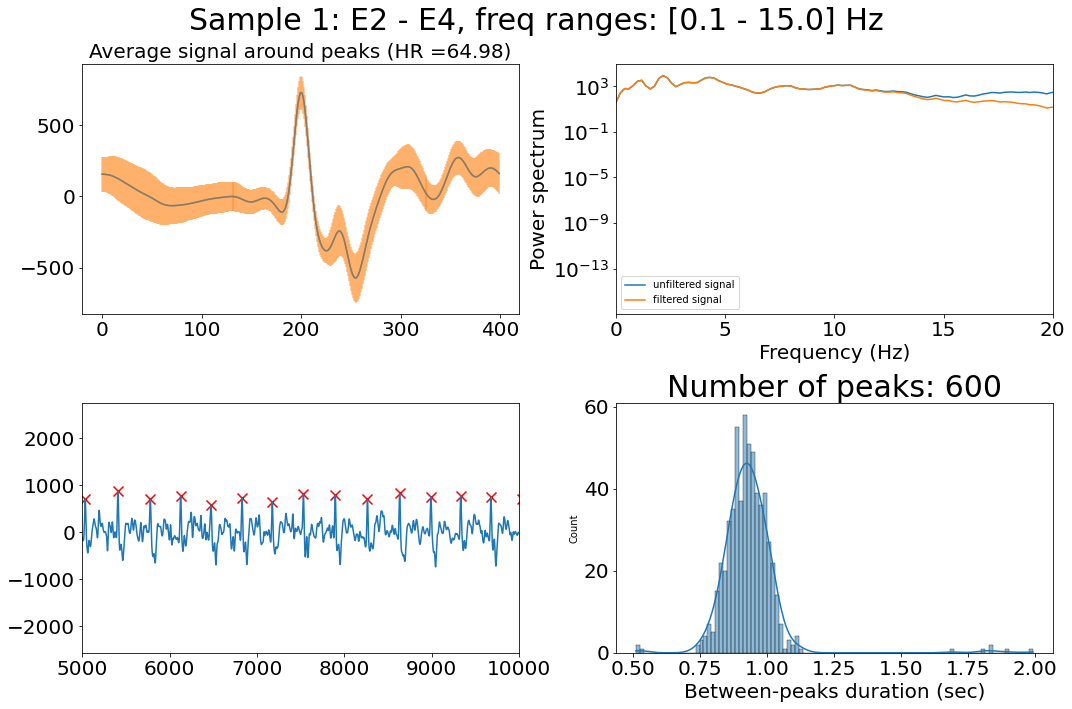

In [149]:
%%time
info,initial_time,final_time,n_vols,n_slices,rep_time = getInfoData('../data/sample1/Physio_sample1_Info.log', range(4))
ecg,_,_ = getECGData("../data/sample1/Physio_sample1_ECG.log", initial_time, final_time)

time_ecg=ecg[:,0]
print(time_ecg[:10])
print("")

ecg_signal=ecg[:,1:]
print(ecg_signal[:10,:])
print("")

fs = 400
low_cut = 0.1
high_cut = 15.0
delta = 200
peak_rise = 0.95

print("ECG sampling rate: %.2f Hz,\n"
     "peak min separation: %.2f,\n"
      "relative peak height min separation: %.2f,\n" % (fs, delta, peak_rise))

ix_1 = 1
ix_2 = 3
ground_ecg = ecg_signal[:,ix_1]
signal = ground_ecg - ecg_signal[:,ix_2] 

generate_plots(signal, low_cut=low_cut, high_cut=high_cut, fs=fs, delta=delta, peak_rise=peak_rise)
plt.suptitle(f"Sample 1: E{ix_1+1} - E{ix_2 +1}, freq ranges: [{low_cut} - {high_cut}] Hz", size=30)
plt.tight_layout()
plt.savefig("../plots/sample1_peaks_f0115_v2.png", dpi=300)
plt.savefig("../plots/sample1_peaks_f0115_v2.pdf", dpi=300)

[21889410. 21889411. 21889412. 21889413. 21889414. 21889415. 21889416.
 21889417. 21889418. 21889419.]

[[2970. 2817. 1905. 1828.]
 [3004. 2827. 1880. 1825.]
 [2992. 2797. 1862. 1831.]
 [2941. 2736. 1850. 1846.]
 [2861. 2652. 1844. 1865.]
 [2763. 2553. 1841. 1888.]
 [2653. 2446. 1837. 1909.]
 [2542. 2339. 1833. 1928.]
 [2440. 2236. 1831. 1942.]
 [2353. 2153. 1834. 1951.]]

ECG sampling rate: 400.00 Hz,
peak min separation: 200.00,
relative peak height min separation: 0.95,



<IPython.core.display.Javascript object>

CPU times: user 3.7 s, sys: 52 ms, total: 3.75 s
Wall time: 3.75 s


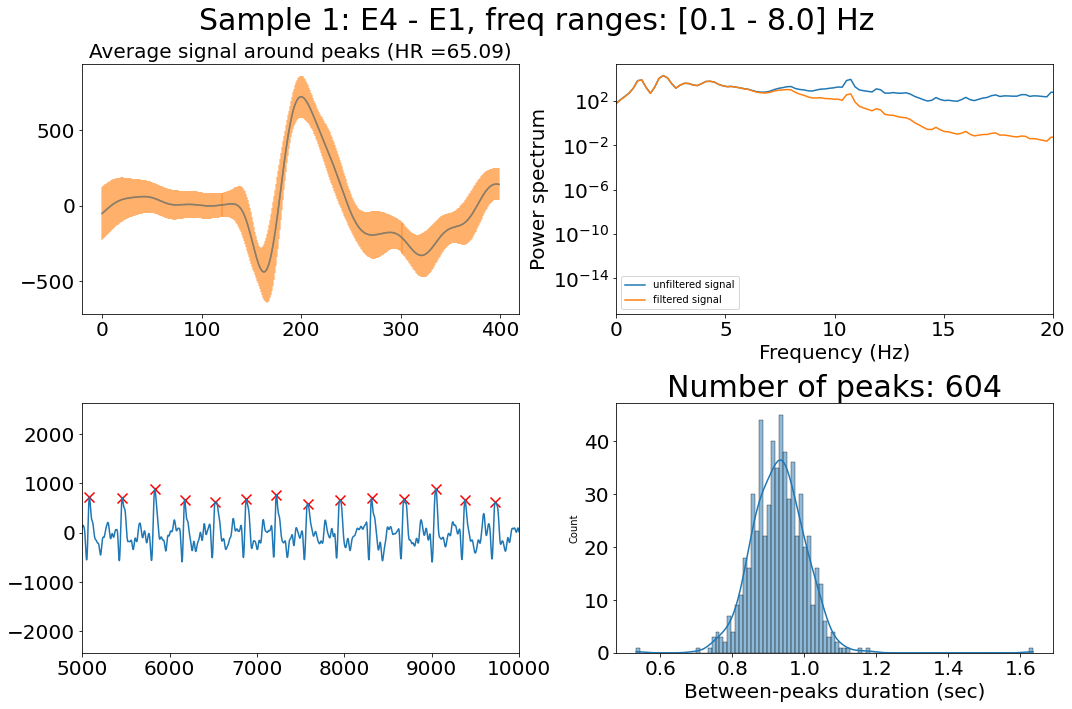

In [154]:
%%time
info,initial_time,final_time,n_vols,n_slices,rep_time = getInfoData('../data/sample1/Physio_sample1_Info.log', range(4))
ecg,_,_ = getECGData("../data/sample1/Physio_sample1_ECG.log", initial_time, final_time)

time_ecg=ecg[:,0]
print(time_ecg[:10])
print("")

ecg_signal=ecg[:,1:]
print(ecg_signal[:10,:])
print("")

fs = 400
low_cut = 0.1
high_cut = 8.0
delta = 200
peak_rise = 0.95

print("ECG sampling rate: %.2f Hz,\n"
     "peak min separation: %.2f,\n"
      "relative peak height min separation: %.2f,\n" % (fs, delta, peak_rise))

ix_1 = 3
ix_2 = 0
ground_ecg = ecg_signal[:,ix_1]
signal = ground_ecg - ecg_signal[:,ix_2] 

generate_plots(signal, low_cut=low_cut, high_cut=high_cut, fs=fs, delta=delta, peak_rise=peak_rise)
plt.suptitle(f"Sample 1: E{ix_1+1} - E{ix_2 +1}, freq ranges: [{low_cut} - {high_cut}] Hz", size=30)
plt.tight_layout()
plt.savefig("../plots/sample1_peaks_e41_f0108.png", dpi=300)
plt.savefig("../plots/sample1_peaks_e41_f0108.pdf", dpi=300)

[22154963. 22154964. 22154965. 22154966. 22154967. 22154968. 22154969.
 22154970. 22154971. 22154972.]

[[2225. 2244. 2070. 2114.]
 [2222. 2246. 2074. 2108.]
 [2219. 2249. 2079. 2101.]
 [2217. 2252. 2085. 2094.]
 [2215. 2254. 2089. 2088.]
 [2214. 2255. 2091. 2082.]
 [2213. 2253. 2091. 2077.]
 [2213. 2251. 2088. 2074.]
 [2213. 2247. 2084. 2071.]
 [2212. 2242. 2080. 2071.]]

ECG sampling rate: 400.00 Hz,
peak min separation: 200.00,
relative peak height min separation: 0.95,



<IPython.core.display.Javascript object>

CPU times: user 3.67 s, sys: 84.1 ms, total: 3.75 s
Wall time: 3.75 s


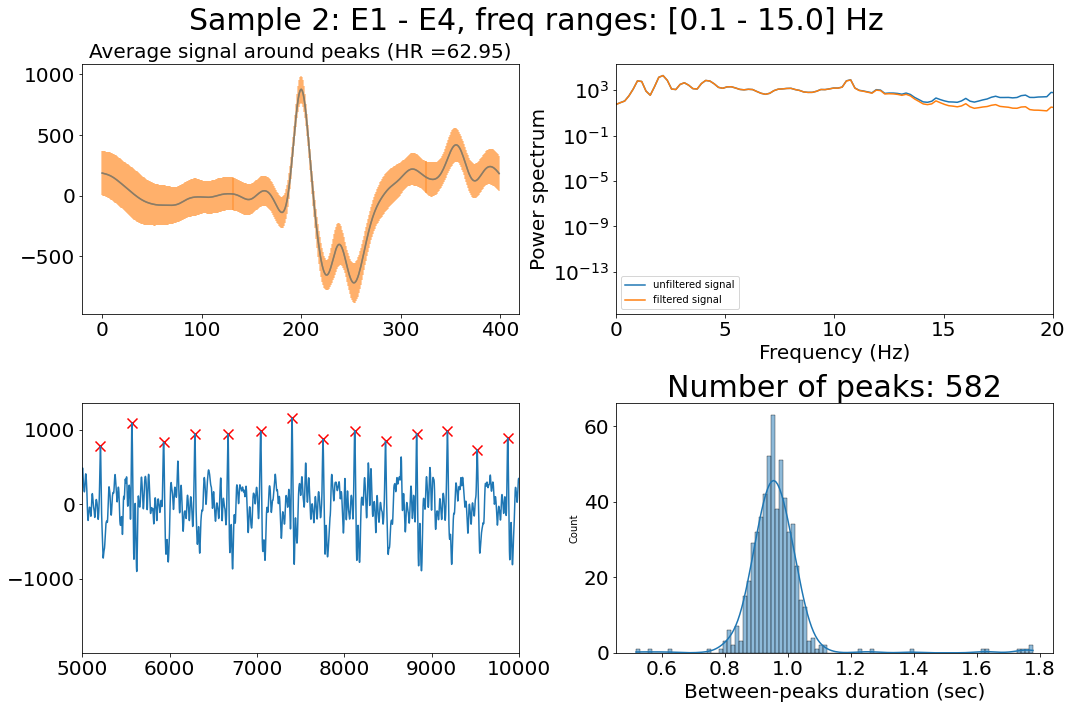

In [150]:
%%time
info,initial_time,final_time,n_vols,n_slices,rep_time = getInfoData('../data/sample2/Physio_sample2_Info.log', range(4))
ecg,_,_ = getECGData("../data/sample2/Physio_sample2_ECG.log", initial_time, final_time)

time_ecg=ecg[:,0]
print(time_ecg[:10])
print("")

ecg_signal=ecg[:,1:]
print(ecg_signal[:10,:])
print("")

fs = 400
low_cut = 0.1
high_cut = 15.0
delta = 200
peak_rise = 0.95

print("ECG sampling rate: %.2f Hz,\n"
     "peak min separation: %.2f,\n"
      "relative peak height min separation: %.2f,\n" % (fs, delta, peak_rise))

ix_1 = 0
ix_2 = 3
ground_ecg = ecg_signal[:,ix_1]

signal = ground_ecg - ecg_signal[:,ix_2] 

generate_plots(signal, low_cut=low_cut, high_cut=high_cut, fs=fs, delta=delta, peak_rise=peak_rise)
plt.suptitle(f"Sample 2: E{ix_1+1} - E{ix_2 +1}, freq ranges: [{low_cut} - {high_cut}] Hz", size=30)
plt.tight_layout()
plt.savefig("../plots/sample2_peaks_f0115.png", dpi=300)
plt.savefig("../plots/sample2_peaks_f0115.pdf", dpi=300)

[22154963. 22154964. 22154965. 22154966. 22154967. 22154968. 22154969.
 22154970. 22154971. 22154972.]

[[2225. 2244. 2070. 2114.]
 [2222. 2246. 2074. 2108.]
 [2219. 2249. 2079. 2101.]
 [2217. 2252. 2085. 2094.]
 [2215. 2254. 2089. 2088.]
 [2214. 2255. 2091. 2082.]
 [2213. 2253. 2091. 2077.]
 [2213. 2251. 2088. 2074.]
 [2213. 2247. 2084. 2071.]
 [2212. 2242. 2080. 2071.]]

ECG sampling rate: 400.00 Hz,
peak min separation: 200.00,
relative peak height min separation: 0.95,



<IPython.core.display.Javascript object>

CPU times: user 3.5 s, sys: 43.9 ms, total: 3.55 s
Wall time: 3.54 s


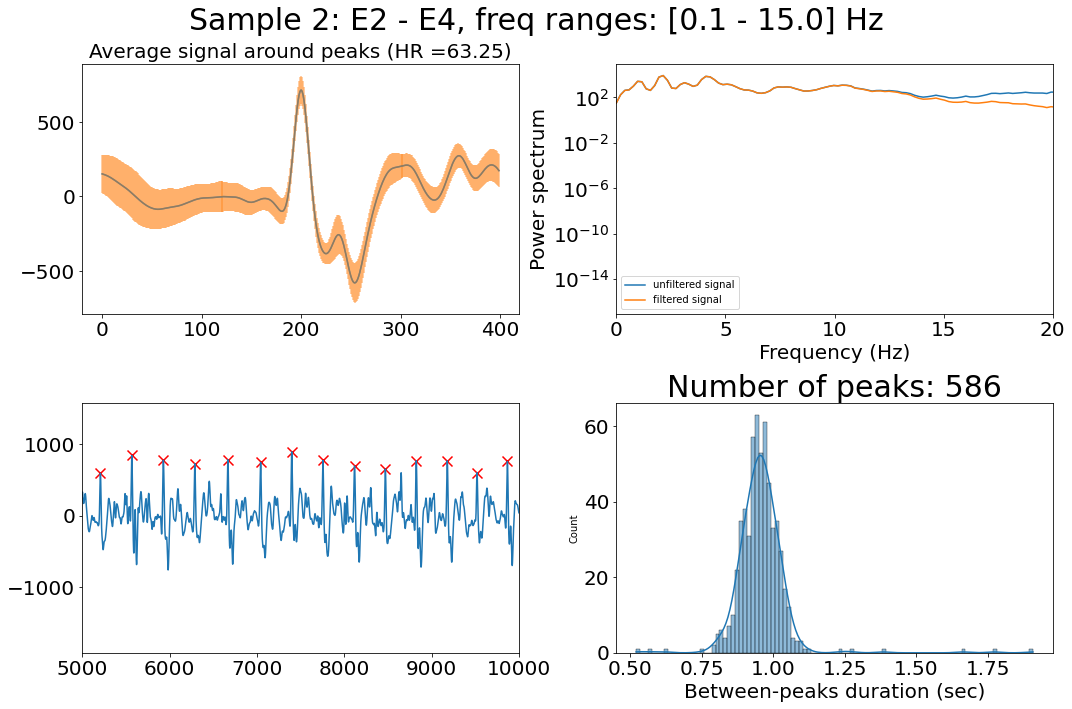

In [151]:
%%time
info,initial_time,final_time,n_vols,n_slices,rep_time = getInfoData('../data/sample2/Physio_sample2_Info.log', range(4))
ecg,_,_ = getECGData("../data/sample2/Physio_sample2_ECG.log", initial_time, final_time)

time_ecg=ecg[:,0]
print(time_ecg[:10])
print("")

ecg_signal=ecg[:,1:]
print(ecg_signal[:10,:])
print("")

fs = 400
low_cut = 0.1
high_cut = 15.0
delta = 200
peak_rise = 0.95

print("ECG sampling rate: %.2f Hz,\n"
     "peak min separation: %.2f,\n"
      "relative peak height min separation: %.2f,\n" % (fs, delta, peak_rise))

ix_1 = 1
ix_2 = 3
ground_ecg = ecg_signal[:,ix_1]

signal = ground_ecg - ecg_signal[:,ix_2] 

generate_plots(signal, low_cut=low_cut, high_cut=high_cut, fs=fs, delta=delta, peak_rise=peak_rise)
plt.suptitle(f"Sample 2: E{ix_1+1} - E{ix_2 +1}, freq ranges: [{low_cut} - {high_cut}] Hz", size=30)
plt.tight_layout()
plt.savefig("../plots/sample2_peaks_f0115_v2.png", dpi=300)
plt.savefig("../plots/sample2_peaks_f0115_v2.pdf", dpi=300)

[22154963. 22154964. 22154965. 22154966. 22154967. 22154968. 22154969.
 22154970. 22154971. 22154972.]

[[2225. 2244. 2070. 2114.]
 [2222. 2246. 2074. 2108.]
 [2219. 2249. 2079. 2101.]
 [2217. 2252. 2085. 2094.]
 [2215. 2254. 2089. 2088.]
 [2214. 2255. 2091. 2082.]
 [2213. 2253. 2091. 2077.]
 [2213. 2251. 2088. 2074.]
 [2213. 2247. 2084. 2071.]
 [2212. 2242. 2080. 2071.]]

ECG sampling rate: 400.00 Hz,
peak min separation: 200.00,
relative peak height min separation: 0.95,



<IPython.core.display.Javascript object>

CPU times: user 3.38 s, sys: 64 ms, total: 3.44 s
Wall time: 3.44 s


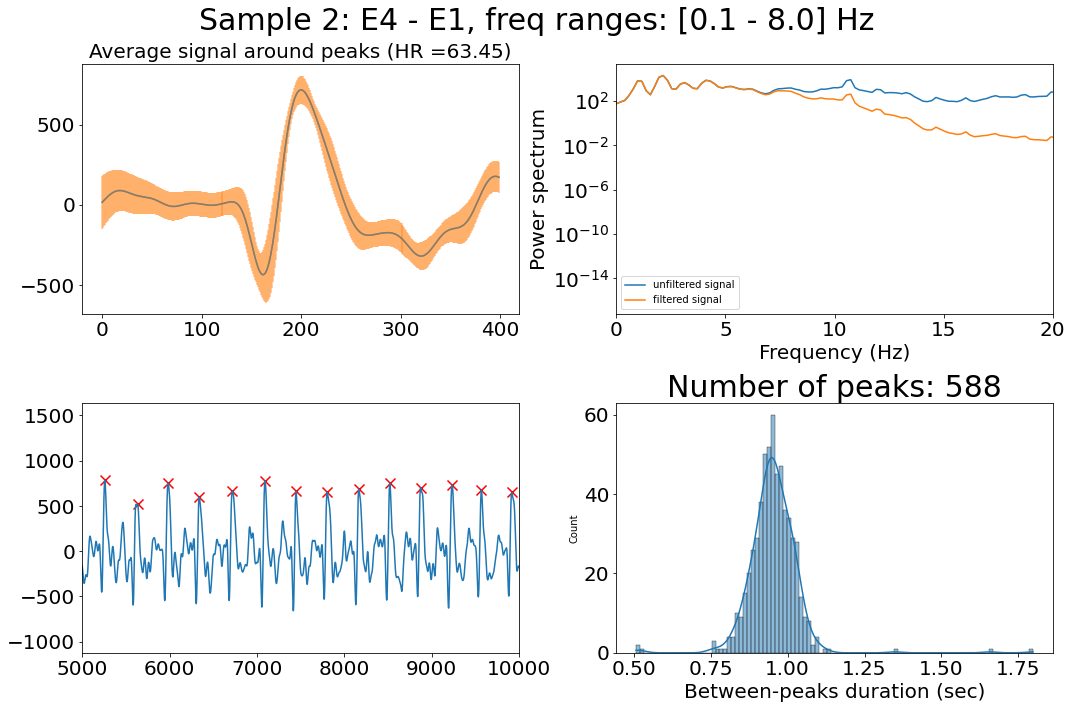

In [157]:
%%time
info,initial_time,final_time,n_vols,n_slices,rep_time = getInfoData('../data/sample2/Physio_sample2_Info.log', range(4))
ecg,_,_ = getECGData("../data/sample2/Physio_sample2_ECG.log", initial_time, final_time)

time_ecg=ecg[:,0]
print(time_ecg[:10])
print("")

ecg_signal=ecg[:,1:]
print(ecg_signal[:10,:])
print("")

fs = 400
low_cut = 0.1
high_cut = 8.0
delta = 200
peak_rise = 0.95

print("ECG sampling rate: %.2f Hz,\n"
     "peak min separation: %.2f,\n"
      "relative peak height min separation: %.2f,\n" % (fs, delta, peak_rise))

ix_1 = 3
ix_2 = 0
ground_ecg = ecg_signal[:,ix_1]
signal = ground_ecg - ecg_signal[:,ix_2] 

generate_plots(signal, low_cut=low_cut, high_cut=high_cut, fs=fs, delta=delta, peak_rise=peak_rise)
plt.suptitle(f"Sample 2: E{ix_1+1} - E{ix_2 +1}, freq ranges: [{low_cut} - {high_cut}] Hz", size=30)
plt.tight_layout()
plt.savefig("../plots/sample2_peaks_e41_f0108.png", dpi=300)
plt.savefig("../plots/sample2_peaks_e41_f0108.pdf", dpi=300)

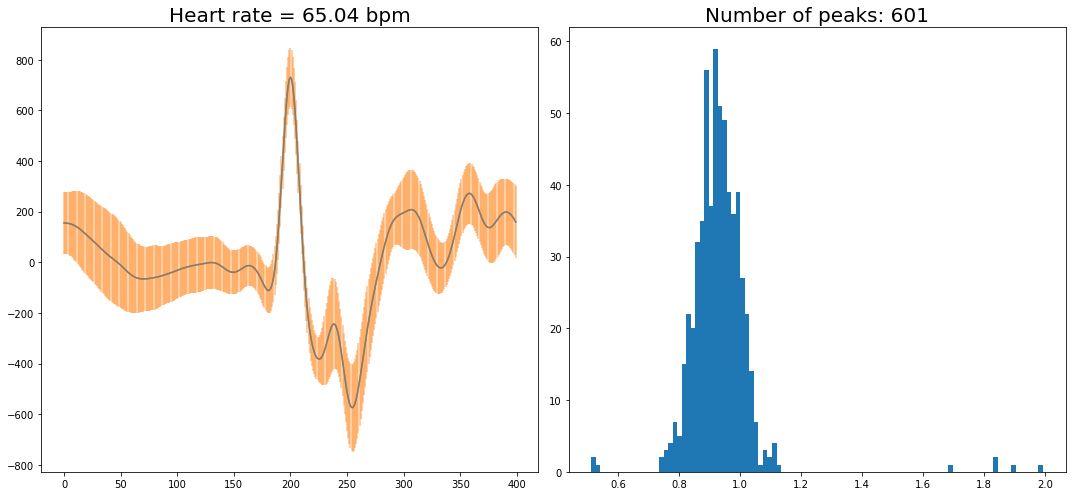

In [60]:
fs = 400
low_cut = 0.1
high_cut = 15.0
delta = 200
peak_rise = 0.9

peak_det_qc(signal, low_cut=low_cut, high_cut=high_cut, fs=fs, delta=delta, peak_rise=peak_rise)

In [58]:
60/0.9

66.66666666666667

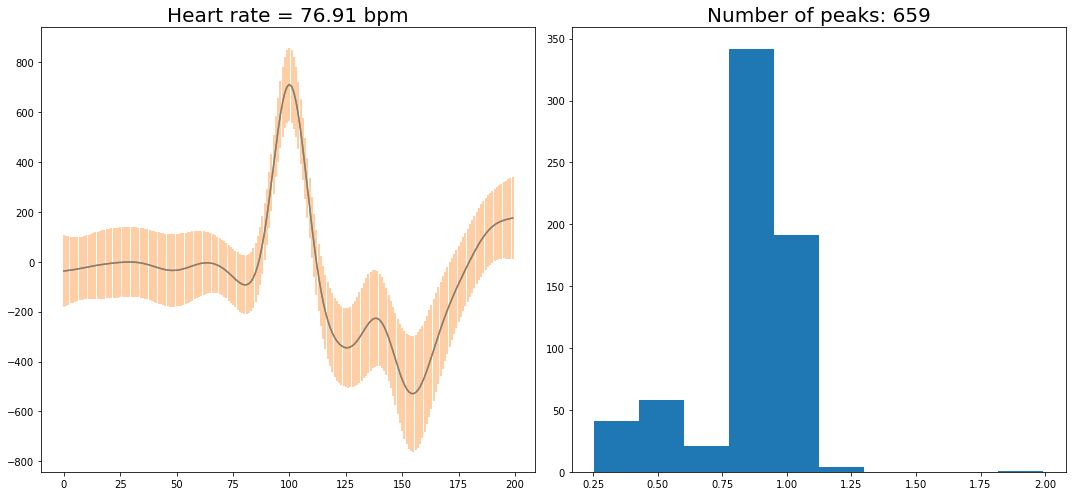

In [25]:
fs = 400
low_cut = 0.1
high_cut = 15.0
delta = 100
peak_rise = 0.75

peak_det_qc(signal, low_cut=low_cut, high_cut=high_cut, fs=fs, delta=delta, peak_rise=peak_rise)

ECG sampling rate: 400.00 Hz,
peak min separation: 200.00,
relative peak height min separation: 0.75,



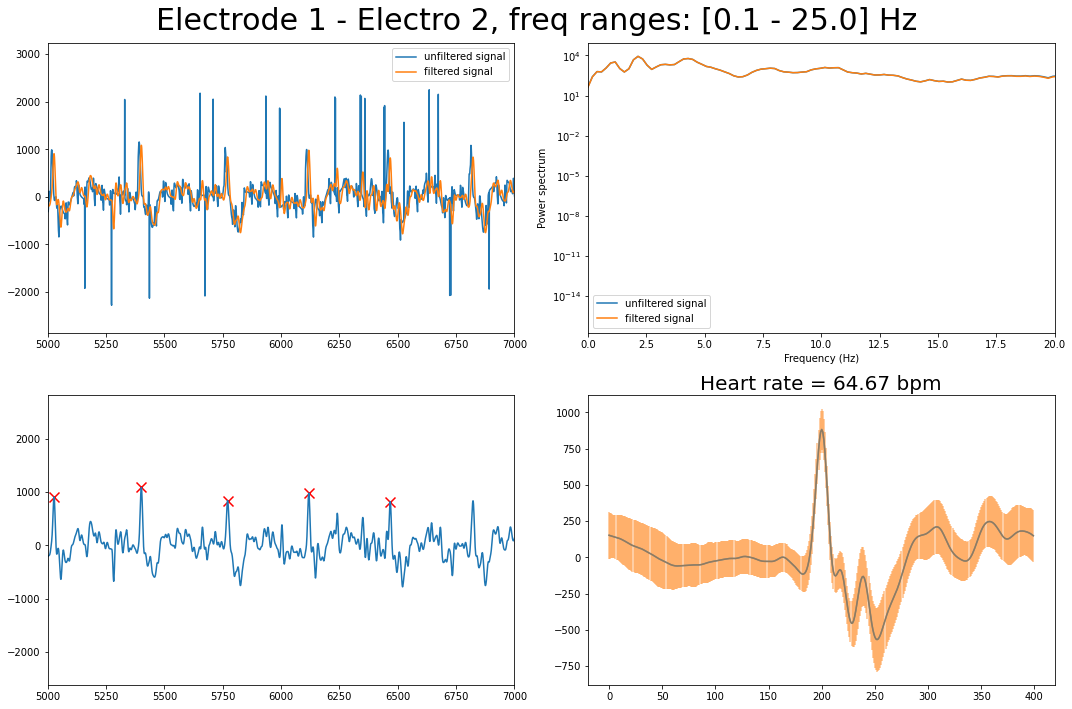

In [15]:
fs = 400
low_cut = 0.1
high_cut = 25.0
delta = 200
peak_rise = 0.75

print("ECG sampling rate: %.2f Hz,\n"
     "peak min separation: %.2f,\n"
      "relative peak height min separation: %.2f,\n" % (fs, delta, peak_rise))


ground_ecg = ecg_signal[:,1]
signal = ground_ecg - ecg_signal[:,3] 

generate_plots(signal, low_cut=low_cut, high_cut=high_cut, fs=fs, delta=delta, peak_rise=peak_rise)
plt.suptitle(f"Electrode 1 - Electro 2, freq ranges: [{low_cut} - {high_cut}] Hz", size=30)
plt.tight_layout()

# Electrode 1 as ground

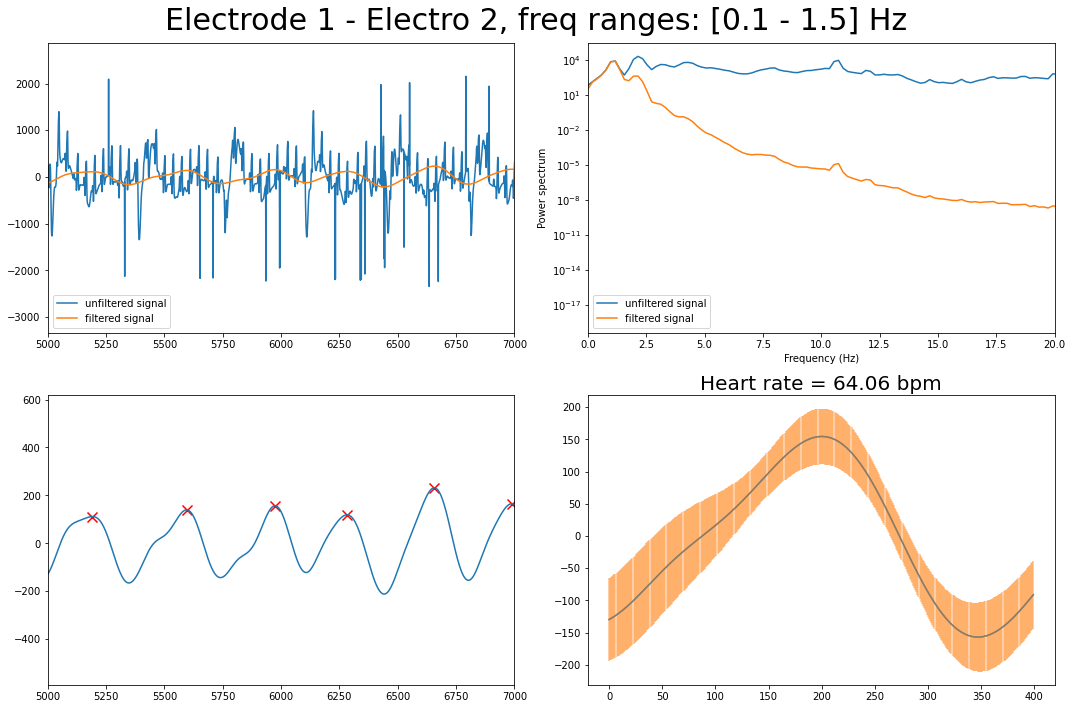

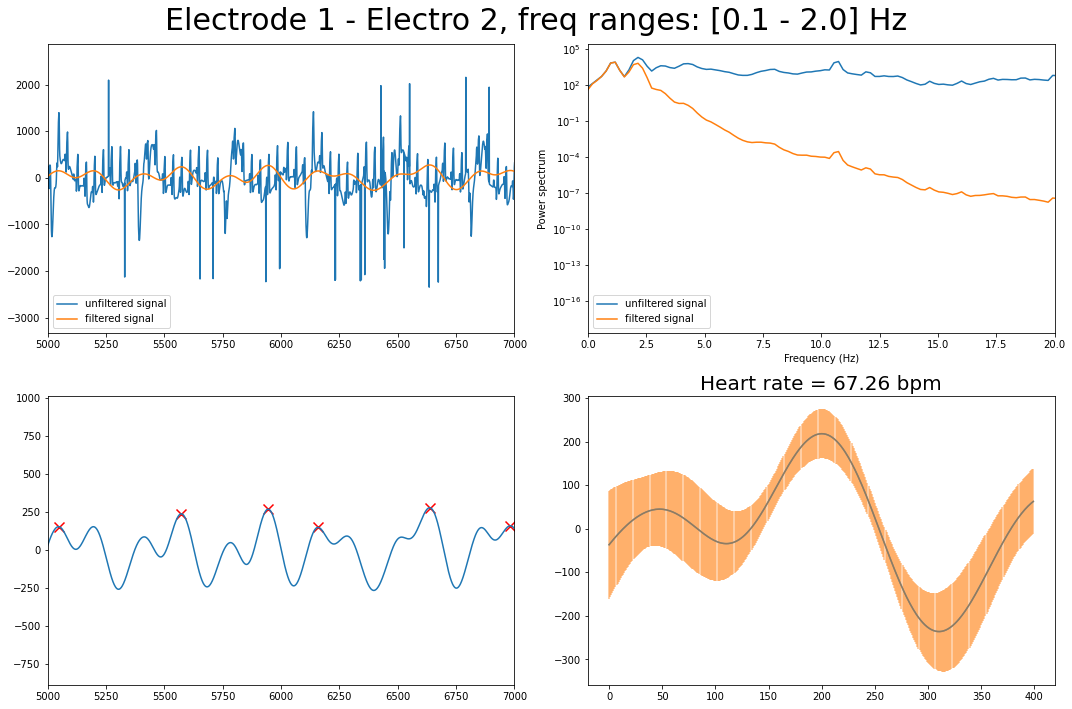

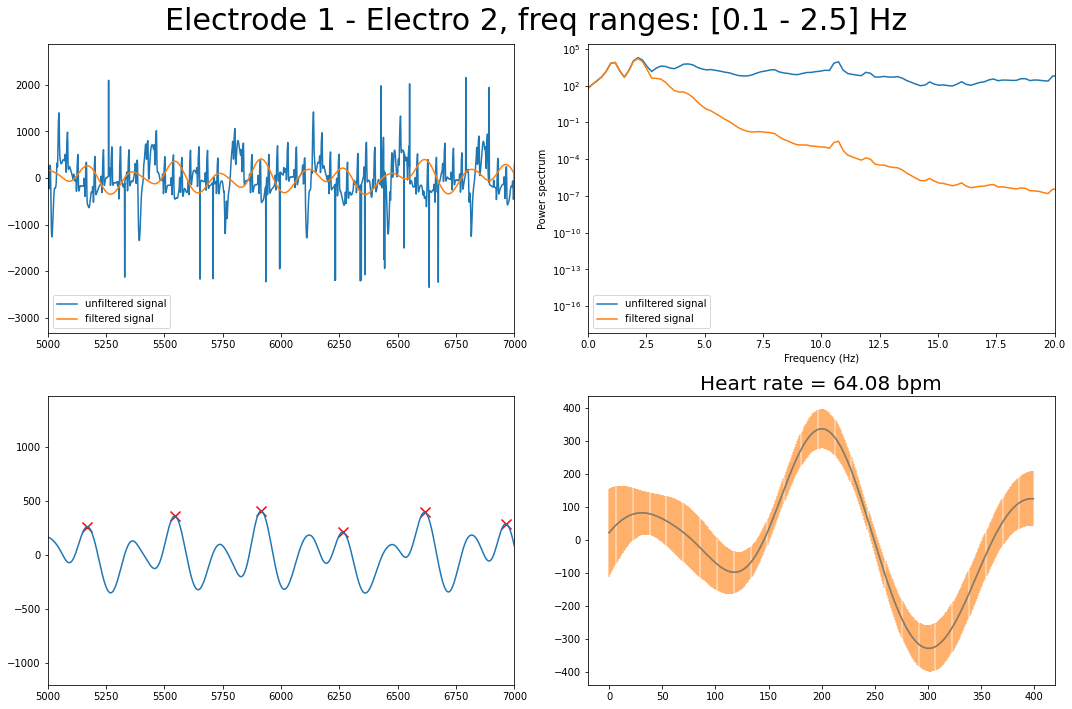

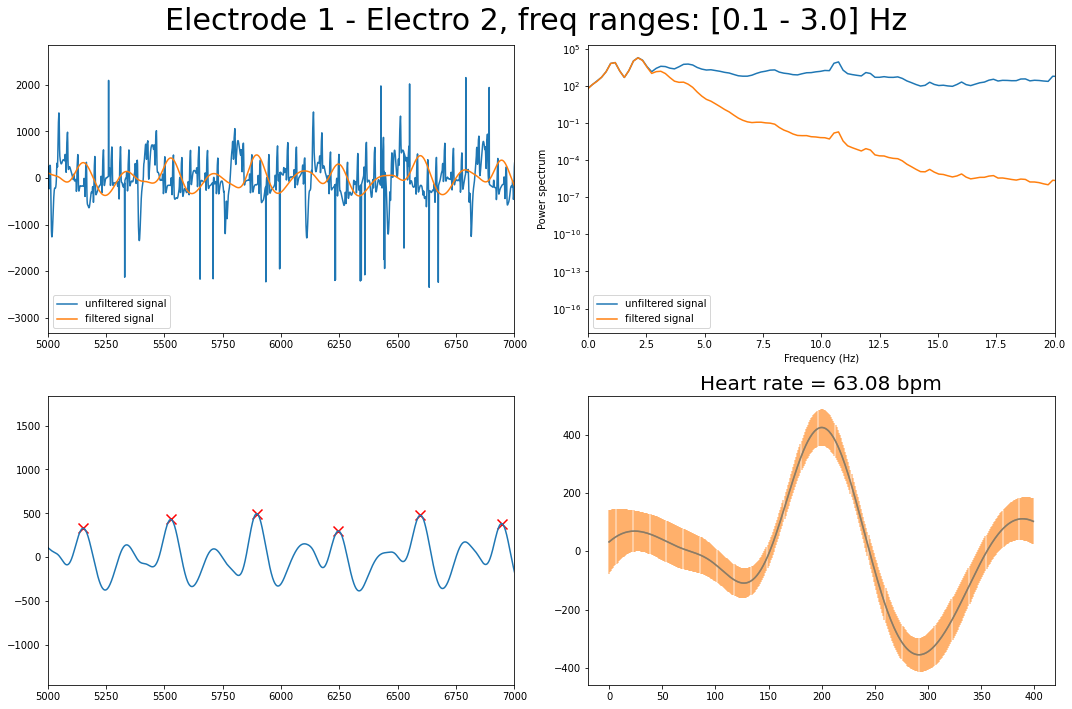

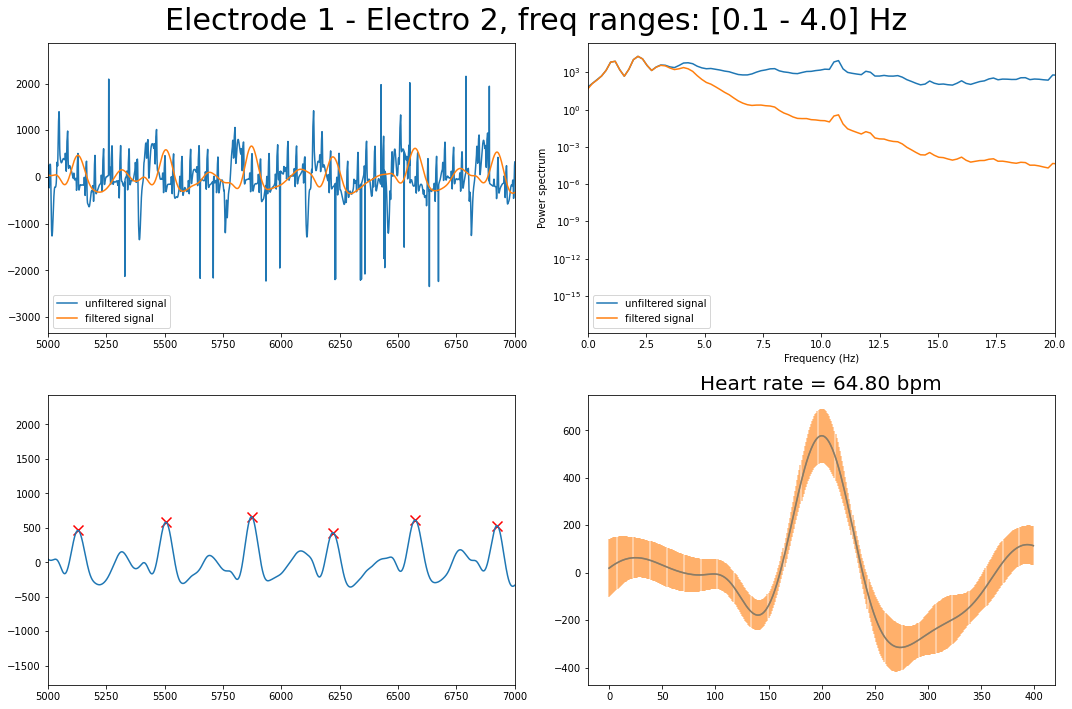

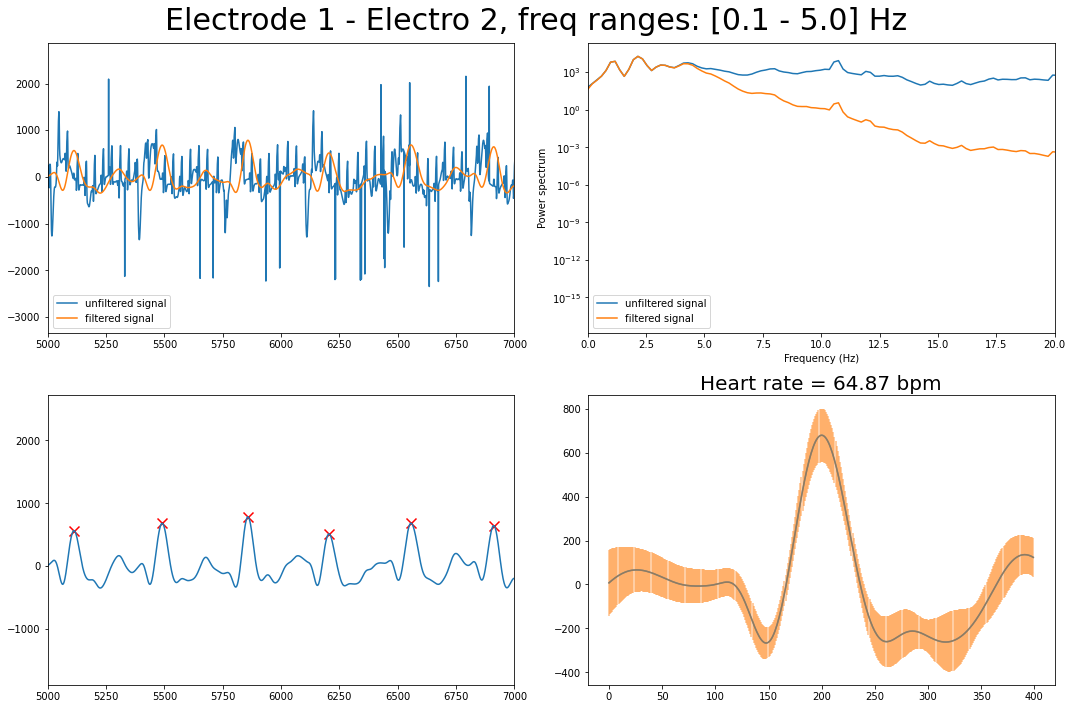

In [9]:
low_cut = 0.1

signal = -ground_ecg+ecg_signal[:,3] 

for high_cut in [1.5, 2., 2.5, 3., 4., 5.]:
    
    generate_plots(signal, low_cut=low_cut, high_cut=high_cut, fs=fs, delta=delta, peak_rise=peak_rise)
    plt.suptitle(f"Electrode 1 - Electro 2, freq ranges: [0.1 - {high_cut}] Hz", size=30)
    plt.tight_layout()

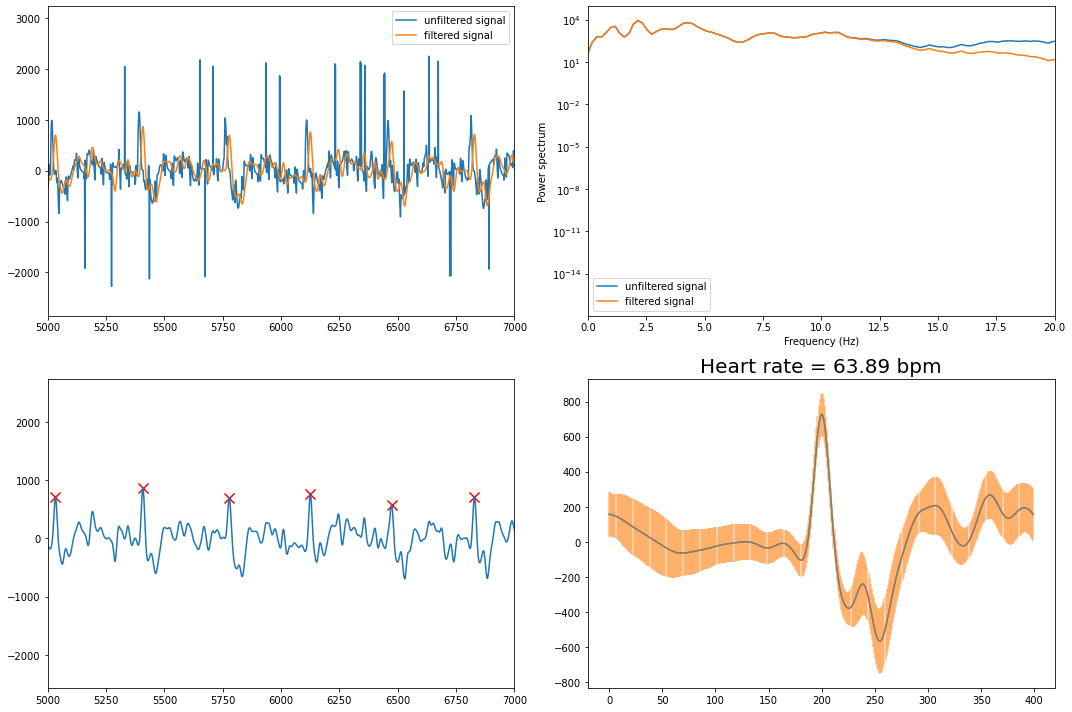

In [38]:
info,initial_time,final_time,n_vols,n_slices,rep_time = getInfoData('../data/sample1/Physio_sample1_Info.log', range(4))
ecg,_,_ = getECGData("../data/sample1/Physio_sample1_ECG.log", initial_time, final_time)
ecg_signal=ecg[:,1:]

signal = ecg_signal[:,1] - ecg_signal[:,3] 

generate_plots(signal, low_cut=.1, high_cut=15, fs=fs, delta=delta, peak_rise=peak_rise)

In [ ]:
from scipy.signal import 

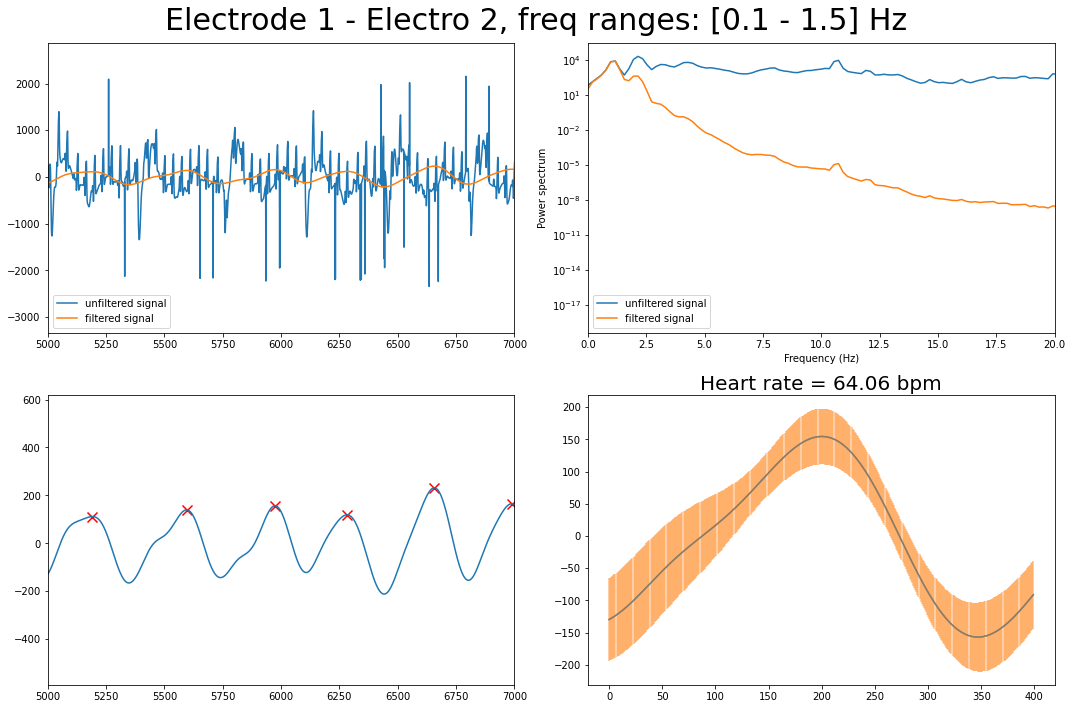

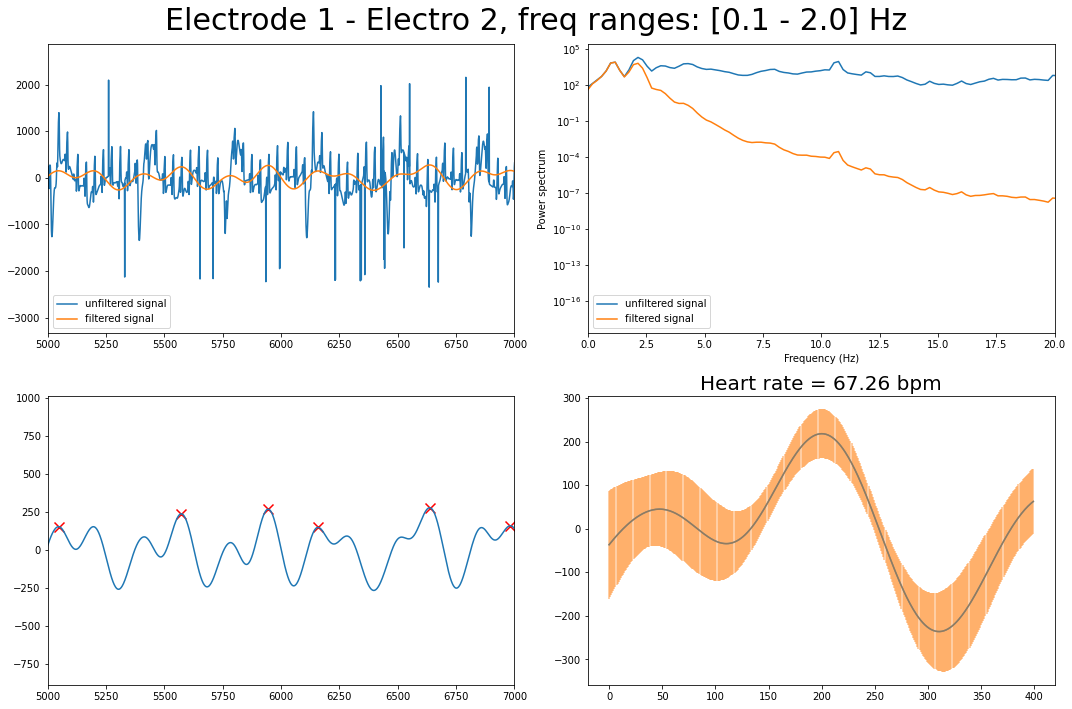

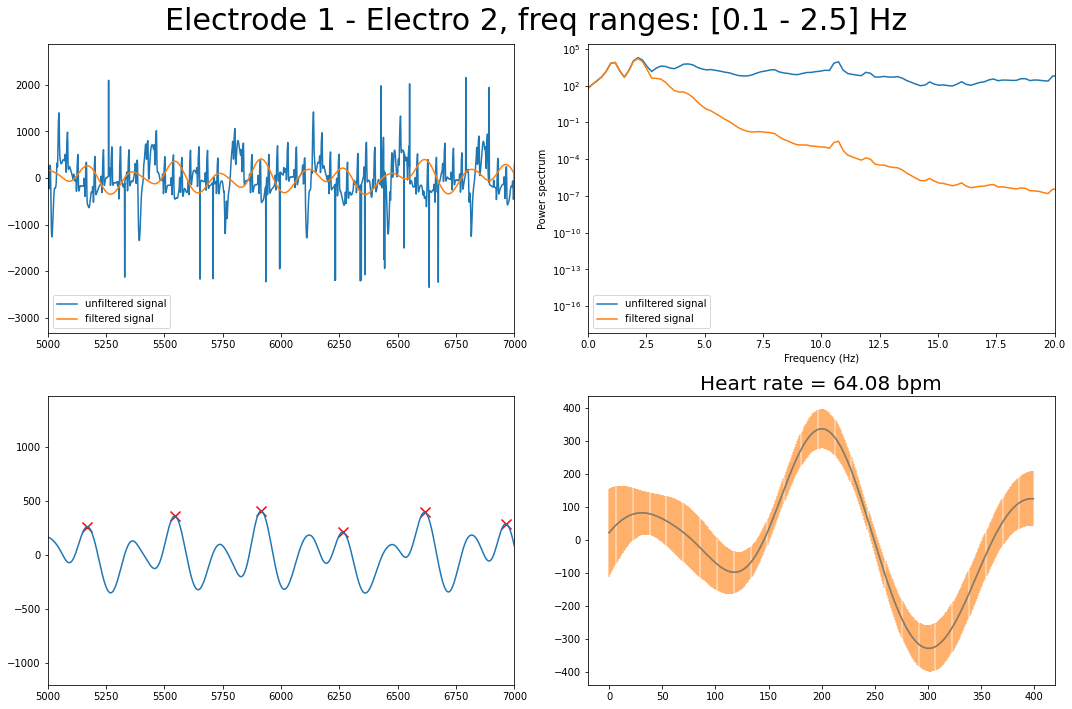

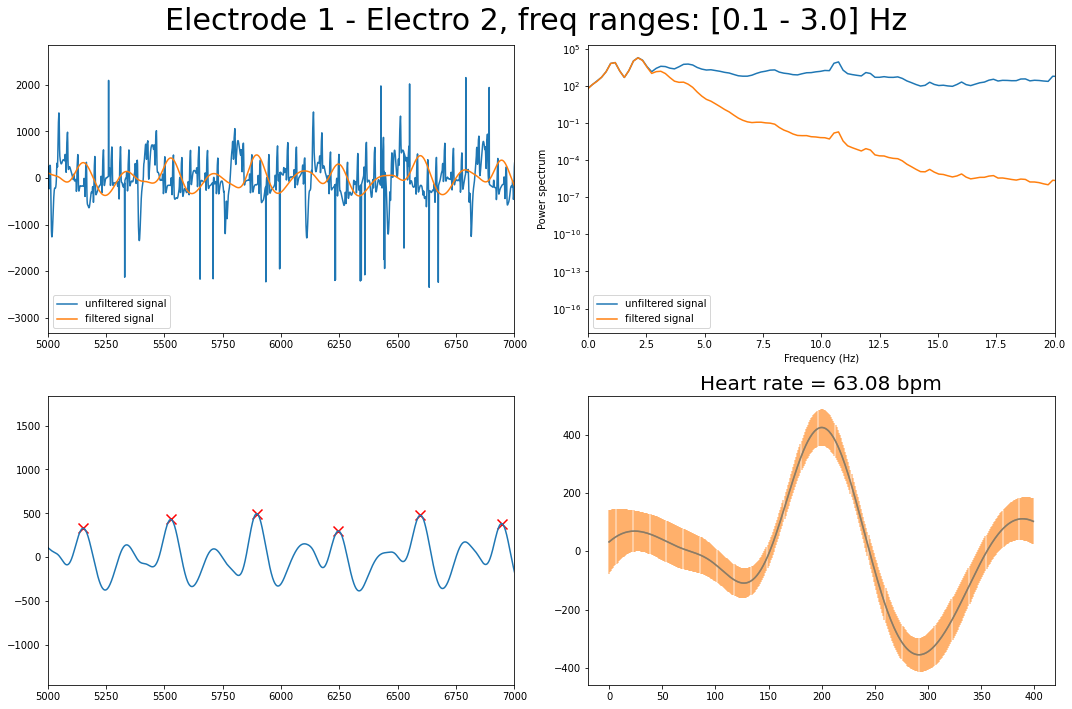

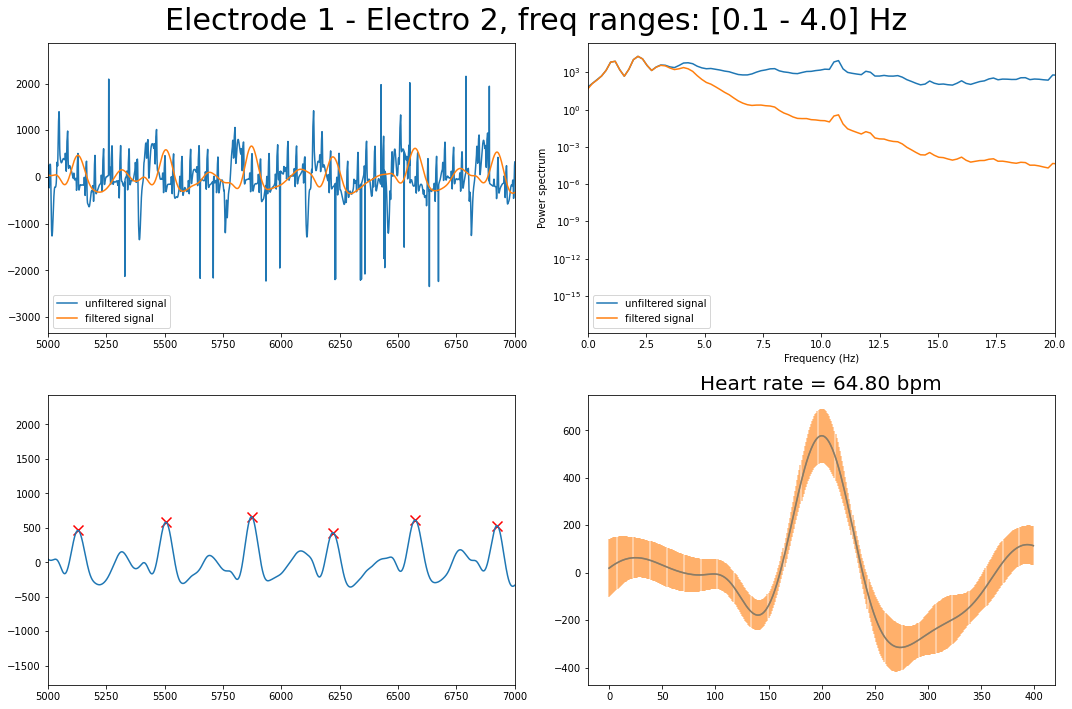

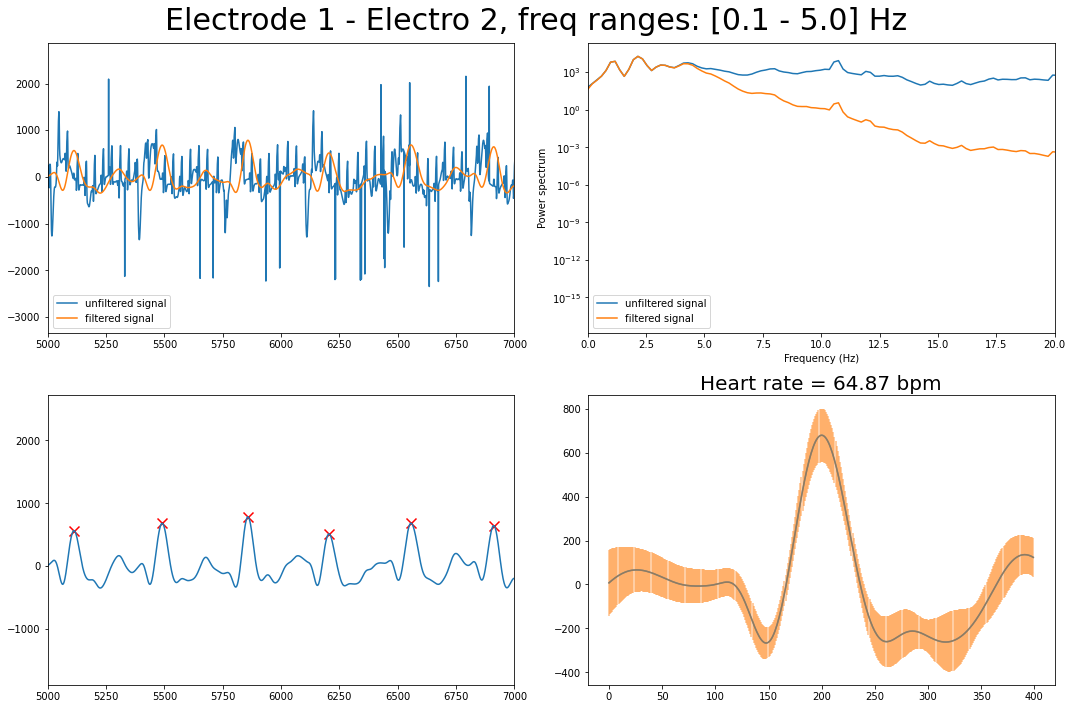

In [11]:
low_cut = 0.1

signal = -ground_ecg+ecg_signal[:,3] 

for high_cut in [1.5, 2., 2.5, 3., 4., 5.]:
    
    generate_plots(signal, low_cut=low_cut, high_cut=high_cut, fs=fs, delta=delta, peak_rise=peak_rise)
    plt.suptitle(f"Electrode 1 - Electro 2, freq ranges: [0.1 - {high_cut}] Hz", size=30)
    plt.tight_layout()

In [50]:
np.corrcoef(ecg_signal.T)

array([[ 1.        ,  0.75183946, -0.54439975, -0.36466691],
       [ 0.75183946,  1.        , -0.21951363, -0.13128012],
       [-0.54439975, -0.21951363,  1.        ,  0.45733338],
       [-0.36466691, -0.13128012,  0.45733338,  1.        ]])

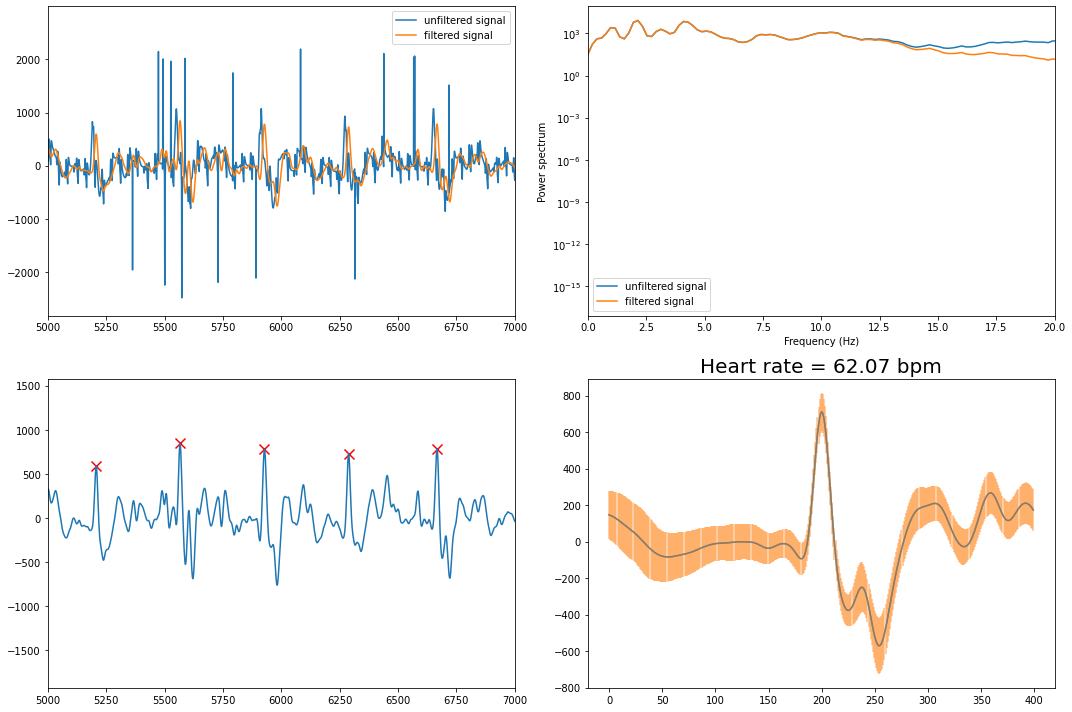

In [36]:
#%matplotlib widget

info,initial_time,final_time,n_vols,n_slices,rep_time = getInfoData('../data/sample2/Physio_sample2_Info.log', range(4))
ecg,_,_ = getECGData("../data/sample2/Physio_sample2_ECG.log", initial_time, final_time)
ecg_signal=ecg[:,1:]

signal = -ecg_signal[:,3] + ecg_signal[:,1] 

generate_plots(signal, low_cut=0.1, high_cut=15, fs=fs, delta=delta, peak_rise=peak_rise)

In [35]:
np.corrcoef(ecg_signal.T)

array([[ 1.        ,  0.71478191, -0.53718478, -0.41273326],
       [ 0.71478191,  1.        , -0.19571865, -0.17338542],
       [-0.53718478, -0.19571865,  1.        ,  0.4697689 ],
       [-0.41273326, -0.17338542,  0.4697689 ,  1.        ]])

In [12]:
time_points

array([     0,      1,      2, ..., 239997, 239998, 239999])

In [28]:
time_points = np.arange(400*600)

test_signal = np.sin(1/(np.pi*400)*time_points) + 0.2*np.sin(1/(np.pi*400)*(time_points + 200))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

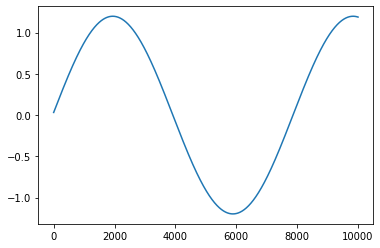

In [29]:
plt.plot(test_signal[:10000])